# Proyecto Polisomnograma

## Santiago Sáez e Ignacio Arnau

**El objetivo de este proyecto, es predecir las etapas del sueño de un paciente dado su polisomnograma. Para ello, disponemos del polisomnograma de varios pacientes**

In [69]:
#Cargamos las librerías necesarias

import mne
import numpy as np
import pandas as pd
import yasa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_validate
from itertools import cycle
from sklearn.preprocessing import label_binarize
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model

Tenemos varios datos. Unos de ellos están dividos en ventanas de 30 segundos que es lo queremos buscar al final. Sin embargo, nosotros queremos preprocesar primero la señal utilizando la librería `yasa` y para ello necesitamos tener la señal entera. Por ello, primero cargaremos la señal entera, la preprocesaremos con `yasa` y después ya dividirla en ventanas de 30 segundos para intentar predecir las etapas del sueño.

Por tanto, cargamos los datos que hemos obtenido de la siguiente página https://sleeptight.isr.uc.pt/, en la sección de *Data*

In [2]:
raw = mne.io.read_raw_edf('Data2/10/10.edf', preload=True)
raw

Extracting EDF parameters from C:\Users\santi\Documents\Biomedicina\trabajo_final\Data2\10\10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4775999  =      0.000 ... 23879.995 secs...


<RawEDF | 10.edf, 19 x 4776000 (23880.0 s), ~692.3 MB, data loaded>

No podemos representar el polisomnograma con `YASA` de manera que podamos hacer scrolling y hacer zoom, pero eso podemos visualizarlo usando el software **EDFBrowser**, el cual es gratuito.

Una vez que tenemos los datos, veamos cuales son los nombres de los canales que han sido estudiados

In [3]:
print(raw.ch_names)

['LOC-A2', 'ROC-A1', 'F3-A2', 'C3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8']


Vemos que tenemos más canales de los que queremos estudiar, ya que los canales que queremos estudiar son los siguientes:

   * F3, C3, O1, F4, C4, O2 correspondiente a los sensores en la cabeza
   * ROC, LOC correspondiente a sensores en los ojos
   * X1, X2, X3 correspondiente a sensores en el mentón, mano y pierna respectivamente
   
Por tanto, tenemos que eliminar canales:

In [4]:
raw.drop_channels(['X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8'])
print(raw.ch_names)

['LOC-A2', 'ROC-A1', 'F3-A2', 'C3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X1', 'X2', 'X3']


Como hemos dicho antes, no podemos hacer una gráfica que nos permita hacer scrolling o hacer zoom, pero si podemos obtener una gráfica de la siguiente manera

Using matplotlib as 2D backend.
Opening raw-browser...


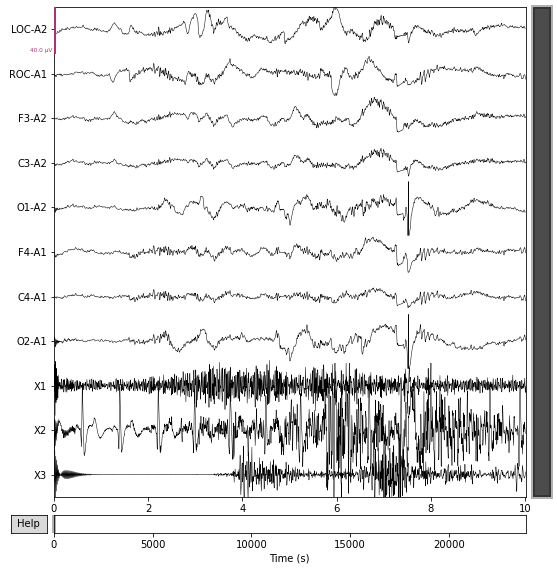

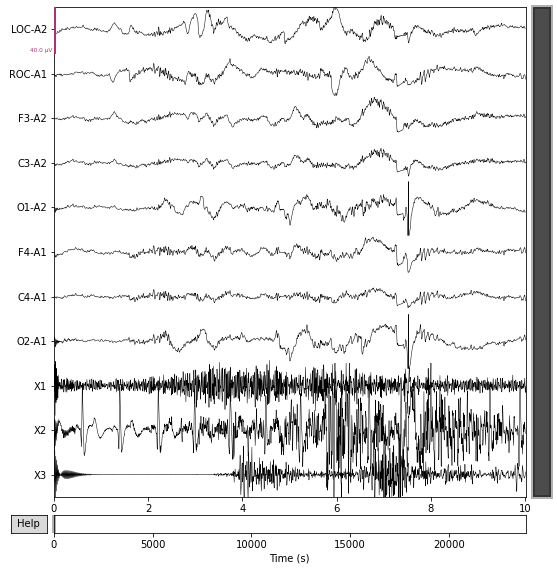

In [5]:
raw.plot()

Se representa toda la señal, sin embargo, debido a la larga duración de la señal, no se puede hacer apreciar muchos detalles.

Preprocesemos la señal: Para ello, veamos cual es la frecuencia de la señal:

In [6]:
print(raw.info['sfreq'])

200.0


Como la frecuencia de la señal es de 200Hz, lo que vamos a hacer es un downsampling para bajar esa frecuencia a 100Hz. Además aplicaremos un filtro de la señal tanto por arriba como por abajo. Para ello hacemos lo siguiente:

In [7]:
#Aplicamos un downsampling

raw.resample(100)

#Aplicamos un filtro de pase de banda

raw.filter(0.3, 49)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 49.50 Hz)
- Filter length: 1101 samples (11.010 sec)



<RawEDF | 10.edf, 11 x 2388000 (23880.0 s), ~200.4 MB, data loaded>

Por último, tenemos que multiplicar los datos por un millón porque `MNE`convierte los datos de microVoltios a Voltios:

In [8]:
data = raw.get_data() * 1e6
print(data.shape)

(11, 2388000)


Los expertos recomiendan quitar las últimas 30 épocas ya que estas no son significativas (quitan los cables a los pacientes, y otros inconvenientes más). Por tanto, como cada época son 30 segundos y por cada segundo coger 100 muestras (la frecuencia de la señal es de 100Hz) tenemos que eliminar las últimas 30 * 30 * 100 = 90.000 muestras. Por tanto, nuestra `data` es:

In [9]:
data = data[:,0:data.shape[1]-90000]
data.shape

(11, 2298000)

Ya hemos preprocesado los datos, por lo que ya podemos trabajar con ellos. Nuestro objetivo es intentar predecir las fases de sueño del paciente, pero para ello, necesitamos saber que características usar para realizar estra predicción de manera correcta. Por ello, para cada etapa (que dura 30 segundos, i.e, tiene 3000 muestras) recogeremos distintas informaciones para cada canal, y estos lo guardaremos en un dataframe que, junto con unas etiquetas que tenemos en otro fichero, se lo pasaremos a un modelo.

El dataframe lo hallamos de la siguiente manera:

In [10]:

df = pd.DataFrame()
for canal, i in zip(raw.ch_names, np.arange(len(raw.ch_names))):
    
    media = []
    sd = []
    nombre_var_mean = canal + '_ mean'
    nombre_var_sd = canal + '_sd'
    for intervalo in np.linspace(0, data.shape[1], int(data.shape[1]/3000 + 1))[1:]:
        media.append(np.mean(data[i, int(intervalo-3000):int(intervalo)]))
        sd.append(np.std(data[i, int(intervalo-3000):int(intervalo)]))
        
    df[nombre_var_mean] = media
    df[nombre_var_sd] = sd

df

,LOC-A2_ mean,LOC-A2_sd,ROC-A1_ mean,ROC-A1_sd,F3-A2_ mean,F3-A2_sd,C3-A2_ mean,C3-A2_sd,O1-A2_ mean,O1-A2_sd,...,C4-A1_ mean,C4-A1_sd,O2-A1_ mean,O2-A1_sd,X1_ mean,X1_sd,X2_ mean,X2_sd,X3_ mean,X3_sd
0,0.006927,4.021722,0.018333,3.596570,0.011094,3.755391,0.010116,2.747480,0.009936,3.647321,...,0.016224,2.252150,0.038539,4.459048,0.015287,3.689803,-0.019304,15.302640,0.001205,2.956899
1,-0.006646,3.246807,-0.010602,2.182392,-0.018794,2.058061,-0.018075,1.776044,-0.017691,1.389548,...,-0.019468,2.174862,-0.042322,1.621868,0.000256,1.957297,0.010936,6.033412,0.000015,0.196091
2,0.005709,3.451683,-0.008072,3.839056,0.010428,2.868421,0.009525,2.692000,0.008664,4.020406,...,0.013250,3.776270,-0.021185,5.929614,-0.000559,2.745204,-0.023980,19.097353,0.000016,0.417095
3,-0.028515,1.879699,0.030409,1.751391,0.007684,1.353437,0.004261,1.208589,0.001523,1.409007,...,-0.002903,1.309005,0.020825,1.174692,0.000492,0.710833,0.013131,6.399490,-0.000001,0.664498
4,0.047296,3.743014,-0.036850,4.160603,0.001107,4.009969,-0.005539,3.121029,0.052842,6.982529,...,0.000107,3.039142,0.032133,5.888576,-0.000398,2.497427,0.003747,16.033665,0.000573,2.583828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,0.024108,1.168500,0.017161,1.150172,0.055698,1.826490,0.056709,1.661326,0.044411,1.370775,...,0.048696,1.683095,0.039625,1.447421,-0.000112,0.268003,0.001149,6.879110,0.000006,0.036565
762,-0.023799,0.948315,-0.017682,0.894644,-0.057538,1.370491,-0.059051,1.309744,-0.042845,1.058809,...,-0.053548,1.141652,-0.038701,1.003774,-0.000004,0.299757,0.004406,6.655113,0.000009,0.048600
763,-0.008568,0.987155,-0.014228,1.003572,-0.009482,1.214643,-0.003111,1.129705,0.005734,0.924405,...,-0.003998,1.102612,0.003255,0.946372,0.000220,0.240521,0.004802,6.980598,0.000002,0.039286
764,0.000332,2.495520,0.021323,2.404687,0.025455,2.299556,0.012994,1.706509,-0.015529,4.341711,...,0.011282,1.802900,-0.011126,3.945259,-0.000130,0.660815,-0.007230,7.449655,-0.000028,2.090885


Lo último que nos hace falta para crear el modelo son las etiquetas que nos indican la fase de sueño del paciente. Estos datos se encuentran en el hipnograma de este, lo cual se carga de siguiente manera:

In [11]:
#Solo vamos a cargar los datos, no vamos a estudiar el hipnograma

hypno = pd.read_excel("Data2/10/10_1.xlsx", squeeze = True)

#Le quitamos las últimas 30 épocas

hypno = hypno.iloc[0:hypno.shape[0]-30]

Para dibujar las curvas _ROC_ de cada clase y la matriz de confusión, vamos a definir dos funciones:

In [12]:
#Para calcular las curvas ROC

def draw_ROC(X_test,y_test):
    
    y_test_b = label_binarize(y_test, classes=['N1', 'N2', 'N3', 'R', 'W'])
    y_score = clf.predict_proba(X_test)
    n_classes = y_test_b.shape[1]

    # Calcule la ROC de cada categoría
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], threshold = roc_curve(y_test_b[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular la curva ROC y el área ROC de micropromedio (Método 2)
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Calcule la curva ROC macro-promedio y el área ROC (Método 1)
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    lw=2
    plt.figure()
    # plt.plot(fpr["micro"], tpr["micro"],
    #          label='micro-average ROC curve (area = {0:0.2f})'
    #                ''.format(roc_auc["micro"]),
    #          color='deeppink', linestyle=':', linewidth=4)

    # plt.plot(fpr["macro"], tpr["macro"],
    #          label='macro-average ROC curve (area = {0:0.2f})'
    #                ''.format(roc_auc["macro"]),
    #          color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

    return threshold

def draw_ConfusionM(matrix,tag_list):
    
    # función que dibuja la matriz de confusión con un heatmap. Le pasas la matriz de confusión calculada con sklearn.metrics y la lista de etiquetas (como se llaman las clases)
    ax = sns.heatmap(matrix, annot=True, cmap='Blues')

    ax.set_title('Confusion Matrix');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(tag_list)
    ax.yaxis.set_ticklabels(tag_list)
    
    ## Display the visualization of the Confusion Matrix.
    plt.show()

Ahora ya podemos utilizar un modelo para predecir los datos. El primero que usaremos será un `RandomForest` donde los datos será el dataframe con las características que hemos hallado y las etiquetas es la variable de `Stage` de `hypno`. Pero antes, tenemos que dividir los datos en datos de datos de entrenamiento y datos de testeo.

In [13]:
#Dividimos los datos en train y test

X_train, X_test, y_train, y_test = train_test_split(df, hypno['Stage'], test_size=0.33, random_state=999)

#Creamos el modelo

clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
pred=clf.predict(X_test)

print(classification_report(pred, y_test))

              precision    recall  f1-score   support

          N1       0.80      0.69      0.74        85
          N2       0.66      0.70      0.68        54
          N3       0.88      0.96      0.92        23
           R       0.96      0.87      0.91        53
           W       0.69      0.87      0.77        38

    accuracy                           0.78       253
   macro avg       0.80      0.82      0.80       253
weighted avg       0.79      0.78      0.78       253



In [14]:
#Obtenemos las mejores características

index=np.argsort(-clf.feature_importances_)
pd.DataFrame({"Variables":df.columns[index], "Importance":clf.feature_importances_[index]})

,Variables,Importance
0,X1_sd,0.164668
1,X3_sd,0.091256
2,O1-A2_sd,0.087224
3,C3-A2_sd,0.077095
4,O2-A1_sd,0.064128
5,LOC-A2_sd,0.063119
6,F3-A2_sd,0.057864
7,F4-A1_sd,0.055081
8,X2_sd,0.052818
9,C4-A1_sd,0.052052


Dibujamos las curvas _ROC_ y las matrices de confusión:

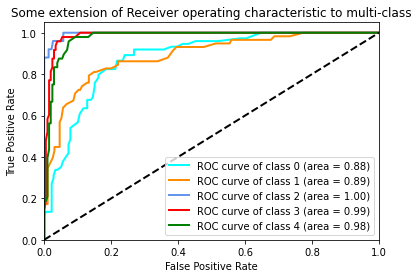

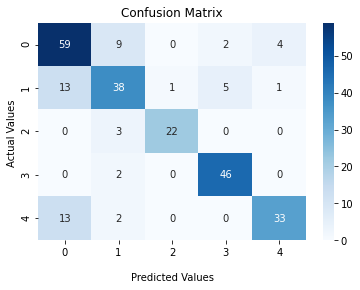

0.9459819142982532

In [15]:
#LLamamos a la función que dibuja la curva ROC

draw_ROC(X_test, y_test)

#Hallamos las entradas de la función que calcula la matriz de confusión

matrix = confusion_matrix(y_test, pred)

#LLamamos a la función que calcula la matriz de confusión

draw_ConfusionM(matrix,np.arange(0,5))

#AUC

roc_auc_score(y_test, clf.predict_proba(X_test),multi_class='ovr')

Utilizaremos ahora un función que nos calcular otro tipo de información para los distintos canales. Esta función es `SleepStaging` de la librería `yasa`,. Al aplicarlo a un canal, nos devuelve toda la información en un DataFrame cuyas filas son las distintas etapas (que duran 30 segundos, como tenemos nosotros anteriormente) y las columnas son las distintas características.

Por tanto, lo que haremos será calcular este DataFrame para cada uno de los canales, los uniremos y después uniremos este con el primer DataFrame que hemos calculado (donde hallamos la media y la desviación típica)

In [16]:
df2 = pd.DataFrame()

for canal in raw.ch_names:
    
    sls = yasa.SleepStaging(raw, eeg_name = canal)
    features = sls.get_features()
    for feat in features.columns:
        
        name_var = feat+'_'+canal
        df2[name_var] = features[feat]

#Quitamos las últimas 30 épocas
df2 = df2.iloc[:-30,:]

#Mostramos el DataFrame
df2

,eeg_abspow_LOC-A2,eeg_abspow_c7min_norm_LOC-A2,eeg_abspow_p2min_norm_LOC-A2,eeg_alpha_LOC-A2,eeg_alpha_c7min_norm_LOC-A2,eeg_alpha_p2min_norm_LOC-A2,eeg_at_LOC-A2,eeg_at_c7min_norm_LOC-A2,eeg_at_p2min_norm_LOC-A2,eeg_beta_LOC-A2,...,eeg_skew_c7min_norm_X3,eeg_skew_p2min_norm_X3,eeg_std_X3,eeg_std_c7min_norm_X3,eeg_std_p2min_norm_X3,eeg_theta_X3,eeg_theta_c7min_norm_X3,eeg_theta_p2min_norm_X3,time_hour_X3,time_norm_X3
epoch,,,,,,,,,,,,,,,,,,,,,
0,5.091902,1.120968,0.946852,0.030264,-0.492477,-0.509266,0.465417,0.265936,-0.066864,0.090873,...,-0.138363,-0.277689,2.368545,1.242101,2.027740,0.018810,0.944784,-0.377652,0.000000,0.000000
1,1.904758,1.169873,0.596920,0.046120,-0.491909,-0.415267,0.844689,0.269352,0.357605,0.133195,...,-0.107527,-0.544785,0.162154,1.177645,1.026360,0.031339,0.997723,0.181528,0.008333,0.001258
2,10.198573,1.223928,1.087355,0.010721,-0.488792,-0.523837,0.459692,0.268462,0.211844,0.049599,...,-0.022805,-0.275780,0.390884,1.195330,0.761774,0.063223,1.023195,1.316584,0.016667,0.002516
3,0.943156,1.217150,0.824474,0.075007,-0.465979,-0.387574,0.849774,0.285237,0.357247,0.223151,...,-0.033862,-0.256390,0.546053,1.260261,0.664692,0.031526,0.877050,1.176788,0.025000,0.003774
4,7.854450,1.234607,0.976131,0.034798,-0.458088,-0.374134,0.705798,0.280135,0.491760,0.113006,...,-0.031186,-0.083232,2.161593,1.319862,0.617729,0.014348,0.743069,1.077219,0.033333,0.005031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,1.247589,0.057010,0.069503,0.048455,-0.116859,-0.177204,0.390370,-0.100937,-0.221213,0.013853,...,0.020328,0.078761,0.030653,-0.066725,-0.093006,0.026994,-0.413153,-0.104339,6.341667,0.957233
762,0.731318,0.053041,0.063099,0.104232,-0.086316,-0.099260,0.393313,-0.064844,-0.262234,0.027525,...,-0.038377,-0.138998,0.042854,0.002574,-0.090851,0.017682,-0.509491,-0.274772,6.350000,0.958491
763,0.791159,0.052362,0.049693,0.080053,-0.078023,-0.047958,0.589284,-0.027798,-0.168304,0.024771,...,-0.048246,-0.137463,0.033556,0.071491,-0.090570,0.020708,-0.573206,-0.236661,6.358333,0.959748


Ahora que tenemos nuestro DataFrame con las nuevas características para los canales, veamos que resultados obtenemos con un `RandomForest`. Así, podremos comparar con el anterior modelo y después uniremos ambos DataFrame para ver si al hacer otro `RandomForest` mejora a los anteriores:

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df2, hypno['Stage'], test_size=0.33, random_state=999)

#Creamos el modelo

clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
pred=clf.predict(X_test)

print(classification_report(pred, y_test))

              precision    recall  f1-score   support

          N1       0.76      0.81      0.78        69
          N2       0.78      0.73      0.75        62
          N3       0.84      1.00      0.91        21
           R       0.98      0.89      0.93        53
           W       0.92      0.92      0.92        48

    accuracy                           0.84       253
   macro avg       0.85      0.87      0.86       253
weighted avg       0.85      0.84      0.84       253



In [18]:
#Obtenemos las mejores características

index=np.argsort(-clf.feature_importances_)
pd.DataFrame({"Variables":df2.columns[index], "Importance":clf.feature_importances_[index]})


,Variables,Importance
0,eeg_beta_p2min_norm_O2-A1,0.017784
1,eeg_perm_p2min_norm_C4-A1,0.010243
2,eeg_abspow_LOC-A2,0.009648
3,eeg_perm_p2min_norm_O2-A1,0.009004
4,eeg_higuchi_c7min_norm_F3-A2,0.008906
...,...,...
710,eeg_ds_p2min_norm_O1-A2,0.000000
711,eeg_hmob_ROC-A1,0.000000
712,eeg_theta_p2min_norm_C4-A1,0.000000
713,eeg_nzc_c7min_norm_O1-A2,0.000000


Dibujamos las curvas _ROC_

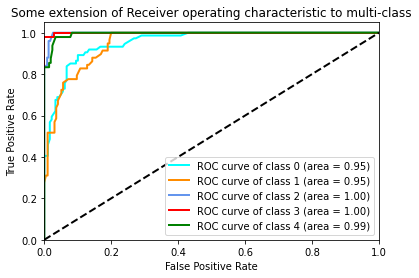

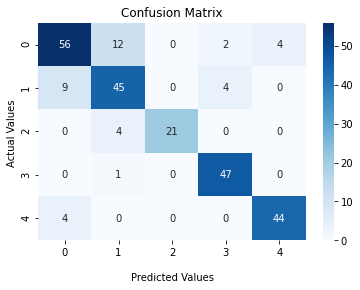

0.9797808753833817

In [19]:
#LLamamos a la función que dibuja la curva ROC

draw_ROC(X_test, y_test)

#Hallamos las entradas de la función que calcula la matriz de confusión

matrix = confusion_matrix(y_test, pred)

#LLamamos a la función que calcula la matriz de confusión

draw_ConfusionM(matrix,np.arange(0,5))

#AUC

roc_auc_score(y_test, clf.predict_proba(X_test),multi_class='ovr')

Observamos que esta predicción es mejor que la anterior, ya que tanto en precisión y en recall los valores son más elevados. Esto tiene sentido puesto que en la primera predicción solo teníamos 22 características y solo considerábamos la media y la desviación típica. Veamos que resultado obtenemos cuando los datos de entrada son los DataFrame `df` y `df2`. Por tanto, unamos ambos DataFrames:

In [20]:
df3 = pd.concat([df, df2], axis = 1)

#Mostramos el DataFrame

df3

,LOC-A2_ mean,LOC-A2_sd,ROC-A1_ mean,ROC-A1_sd,F3-A2_ mean,F3-A2_sd,C3-A2_ mean,C3-A2_sd,O1-A2_ mean,O1-A2_sd,...,eeg_skew_c7min_norm_X3,eeg_skew_p2min_norm_X3,eeg_std_X3,eeg_std_c7min_norm_X3,eeg_std_p2min_norm_X3,eeg_theta_X3,eeg_theta_c7min_norm_X3,eeg_theta_p2min_norm_X3,time_hour_X3,time_norm_X3
0,0.006927,4.021722,0.018333,3.596570,0.011094,3.755391,0.010116,2.747480,0.009936,3.647321,...,-0.138363,-0.277689,2.368545,1.242101,2.027740,0.018810,0.944784,-0.377652,0.000000,0.000000
1,-0.006646,3.246807,-0.010602,2.182392,-0.018794,2.058061,-0.018075,1.776044,-0.017691,1.389548,...,-0.107527,-0.544785,0.162154,1.177645,1.026360,0.031339,0.997723,0.181528,0.008333,0.001258
2,0.005709,3.451683,-0.008072,3.839056,0.010428,2.868421,0.009525,2.692000,0.008664,4.020406,...,-0.022805,-0.275780,0.390884,1.195330,0.761774,0.063223,1.023195,1.316584,0.016667,0.002516
3,-0.028515,1.879699,0.030409,1.751391,0.007684,1.353437,0.004261,1.208589,0.001523,1.409007,...,-0.033862,-0.256390,0.546053,1.260261,0.664692,0.031526,0.877050,1.176788,0.025000,0.003774
4,0.047296,3.743014,-0.036850,4.160603,0.001107,4.009969,-0.005539,3.121029,0.052842,6.982529,...,-0.031186,-0.083232,2.161593,1.319862,0.617729,0.014348,0.743069,1.077219,0.033333,0.005031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,0.024108,1.168500,0.017161,1.150172,0.055698,1.826490,0.056709,1.661326,0.044411,1.370775,...,0.020328,0.078761,0.030653,-0.066725,-0.093006,0.026994,-0.413153,-0.104339,6.341667,0.957233
762,-0.023799,0.948315,-0.017682,0.894644,-0.057538,1.370491,-0.059051,1.309744,-0.042845,1.058809,...,-0.038377,-0.138998,0.042854,0.002574,-0.090851,0.017682,-0.509491,-0.274772,6.350000,0.958491
763,-0.008568,0.987155,-0.014228,1.003572,-0.009482,1.214643,-0.003111,1.129705,0.005734,0.924405,...,-0.048246,-0.137463,0.033556,0.071491,-0.090570,0.020708,-0.573206,-0.236661,6.358333,0.959748
764,0.000332,2.495520,0.021323,2.404687,0.025455,2.299556,0.012994,1.706509,-0.015529,4.341711,...,-0.062181,-0.182188,1.697203,0.181110,0.287229,0.003300,-0.604923,-0.523987,6.366667,0.961006


Probamos estos datos siguiendo los pasos anteriores:

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df3, hypno['Stage'], test_size=0.33, random_state=999)

#Creamos el modelo

clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
pred=clf.predict(X_test)

print(classification_report(pred, y_test))



              precision    recall  f1-score   support

          N1       0.78      0.82      0.80        71
          N2       0.76      0.75      0.75        59
          N3       0.84      1.00      0.91        21
           R       0.98      0.89      0.93        53
           W       0.94      0.92      0.93        49

    accuracy                           0.85       253
   macro avg       0.86      0.87      0.86       253
weighted avg       0.85      0.85      0.85       253



Los resultados que obtenemos son muy parecidos a los anteriores, por lo que podríamos concluir que la media y la desviación típica no son muy importantes para clasificar en este caso. Sin embargo, veamos cuales son las variables más importantes:

In [22]:
#Obtenemos las mejores características

index=np.argsort(-clf.feature_importances_)
pd.DataFrame({"Variables":df3.columns[index], "Importance":clf.feature_importances_[index]})

,Variables,Importance
0,eeg_db_p2min_norm_C4-A1,0.015415
1,eeg_abspow_p2min_norm_X1,0.014780
2,eeg_beta_p2min_norm_F4-A1,0.014048
3,eeg_beta_p2min_norm_X1,0.013113
4,eeg_theta_O1-A2,0.012414
...,...,...
732,eeg_ds_C4-A1,0.000000
733,eeg_sdelta_F3-A2,0.000000
734,eeg_nzc_c7min_norm_F3-A2,0.000000
735,F3-A2_ mean,0.000000


Veamos la curva ROC y el AUC:

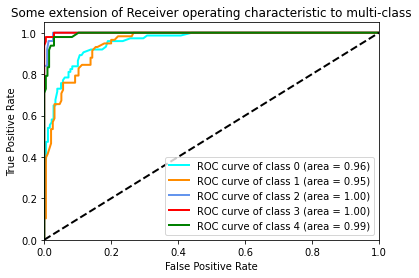

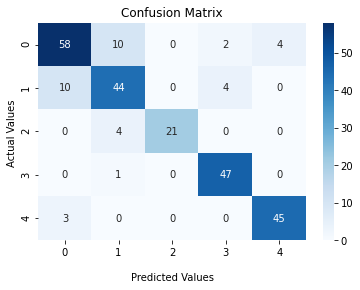

0.9799730725871239

In [23]:
#LLamamos a la función que dibuja la curva ROC

draw_ROC(X_test, y_test)

#Hallamos las entradas de la función que calcula la matriz de confusión

matrix = confusion_matrix(y_test, pred)

#LLamamos a la función que calcula la matriz de confusión

draw_ConfusionM(matrix,np.arange(0,5))

#AUC

roc_auc_score(y_test, clf.predict_proba(X_test),multi_class='ovr')

## Predicciones entrenando con 2 pacientes y testeando con 1

Lo siguiente que vamos a hacer es entrenar un modelo de clasificación con dos pacientes (el 8 y el 9) y despúes prediciremos con el paciente 10. Para ello vamos a seguir los siguientes pasos:

    1. Cargamos las rawData y las preprocesamos como al principio
    2. Calculamos los DataFrames con las características anteriores para el paciente 8, el paciente 9 y el paciente 10
    3. Unimos los DataFrames correspondientes a los pacientes 8 y los pacientes 9.
    4. Entrenamos un RandomForest con el DataFrame resultante
    5. Predecimos las fases de sueño con los datos del paciente 10
    6. Observamos los resultados
    
Así empezamos cargando los datos y preprocensándolos

In [24]:
#Cargamos el rawData del paciente 8, 9 y 10

raw7 = mne.io.read_raw_edf('Data2/7/7.edf', preload=True)
raw8 = mne.io.read_raw_edf('Data2/8/8.edf', preload=True)
raw9 = mne.io.read_raw_edf('Data2/9/9.edf', preload=True)
raw10 = mne.io.read_raw_edf('Data2/10/10.edf', preload=True)

#Eliminamos los canales que no necesitamos
raw7.drop_channels(['X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8'])

raw8.drop_channels(['X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8'])
print(raw.ch_names)

raw9.drop_channels(['X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8'])
print(raw.ch_names)

raw10.drop_channels(['X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8'])
print(raw.ch_names)

#Aplicamos un downsampling

raw7.resample(100)
raw8.resample(100)
raw9.resample(100)
raw10.resample(100)

#Aplicamos un filtro de pase de banda
              
raw7.filter(0.3, 49)
raw8.filter(0.3, 49)
raw9.filter(0.3, 49)
raw10.filter(0.3, 49)

#Multiplicamos un millo para pasar de Voltios a microVoltios

data7 = raw7.get_data() * 1e6
data8 = raw8.get_data() * 1e6
data9 = raw9.get_data() * 1e6
data10 = raw10.get_data() * 1e6

#Eliminamos las últimas 30 etapas

data7 = data7[:,0:-30*30*100]
data8 = data8[:,0:-30*30*100]
data9 = data9[:,0:-30*30*100]
data10 = data10[:,0:-30*30*100]

Extracting EDF parameters from C:\Users\santi\Documents\Biomedicina\trabajo_final\Data2\7\7.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4883999  =      0.000 ... 24419.995 secs...
Extracting EDF parameters from C:\Users\santi\Documents\Biomedicina\trabajo_final\Data2\8\8.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999999  =      0.000 ... 29999.995 secs...
Extracting EDF parameters from C:\Users\santi\Documents\Biomedicina\trabajo_final\Data2\9\9.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5813999  =      0.000 ... 29069.995 secs...
Extracting EDF parameters from C:\Users\santi\Documents\Biomedicina\trabajo_final\Data2\10\10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4775999  =      0.000 ... 23879.995 secs...
['LOC-A2', 'ROC-A1', 'F3-A2', 'C3-A2',

Ahora, calculamos los DataFrames de los pacientes

In [25]:
################# Paciente 7

######### DataFrame con media y desviación típica

df7_1 = pd.DataFrame()

for canal, i in zip(raw7.ch_names, np.arange(len(raw7.ch_names))):
    
    media = []
    sd = []
    nombre_var_mean = canal + '_ mean'
    nombre_var_sd = canal + '_sd'
    for intervalo in np.linspace(0, data7.shape[1], int(data7.shape[1]/3000 + 1))[1:]:
        media.append(np.mean(data7[i, int(intervalo-3000):int(intervalo)]))
        sd.append(np.std(data7[i, int(intervalo-3000):int(intervalo)]))
        
    df7_1[nombre_var_mean] = media
    df7_1[nombre_var_sd] = sd

######### DataFrame con características obtenidas por yasa

df7_2 = pd.DataFrame()

for canal in raw7.ch_names:
    
    sls = yasa.SleepStaging(raw7, eeg_name = canal)
    features = sls.get_features()
    for feat in features.columns:
        
        name_var = feat+'_'+canal
        df7_2[name_var] = features[feat]

#Quitamos las últimas 30 épocas
df7_2 = df7_2.iloc[:-30,:]

######### Obtenemos el DataFrame final

df7_3 = pd.concat([df7_1, df7_2], axis = 1)


################# Paciente 8

######### DataFrame con media y desviación típica

df8_1 = pd.DataFrame()

for canal, i in zip(raw8.ch_names, np.arange(len(raw8.ch_names))):
    
    media = []
    sd = []
    nombre_var_mean = canal + '_ mean'
    nombre_var_sd = canal + '_sd'
    for intervalo in np.linspace(0, data8.shape[1], int(data8.shape[1]/3000 + 1))[1:]:
        media.append(np.mean(data8[i, int(intervalo-3000):int(intervalo)]))
        sd.append(np.std(data8[i, int(intervalo-3000):int(intervalo)]))
        
    df8_1[nombre_var_mean] = media
    df8_1[nombre_var_sd] = sd

######### DataFrame con características obtenidas por yasa

df8_2 = pd.DataFrame()

for canal in raw8.ch_names:
    
    sls = yasa.SleepStaging(raw8, eeg_name = canal)
    features = sls.get_features()
    for feat in features.columns:
        
        name_var = feat+'_'+canal
        df8_2[name_var] = features[feat]

#Quitamos las últimas 30 épocas

df8_2 = df8_2.iloc[:-30,:]

######### Obtenemos el DataFrame final

df8_3 = pd.concat([df8_1, df8_2], axis = 1)


######################### Paciente 9

######### DataFrame con media y desviación típica

df9_1 = pd.DataFrame()

for canal, i in zip(raw9.ch_names, np.arange(len(raw9.ch_names))):
    
    media = []
    sd = []
    nombre_var_mean = canal + '_ mean'
    nombre_var_sd = canal + '_sd'
    
    for intervalo in np.linspace(0, data9.shape[1], int(data9.shape[1]/3000 + 1))[1:]:
        
        media.append(np.mean(data9[i, int(intervalo-3000):int(intervalo)]))
        sd.append(np.std(data9[i, int(intervalo-3000):int(intervalo)]))
        
    df9_1[nombre_var_mean] = media
    df9_1[nombre_var_sd] = sd

######### DataFrame con características obtenidas por yasa

df9_2 = pd.DataFrame()

for canal in raw9.ch_names:
    
    sls = yasa.SleepStaging(raw9, eeg_name = canal)
    features = sls.get_features()
    for feat in features.columns:
        
        name_var = feat+'_'+canal
        df9_2[name_var] = features[feat]

#Quitamos las últimas 30 épocas
df9_2 = df9_2.iloc[:-30,:]

######### Obtenemos el DataFrame final

df9_3 = pd.concat([df9_1, df9_2], axis = 1)


######################### Paciente 10

######### DataFrame con media y desviación típica

df10_1 = pd.DataFrame()

for canal, i in zip(raw10.ch_names, np.arange(len(raw10.ch_names))):
    
    media = []
    sd = []
    nombre_var_mean = canal + '_ mean'
    nombre_var_sd = canal + '_sd'
    for intervalo in np.linspace(0, data10.shape[1], int(data10.shape[1]/3000 + 1))[1:]:
        media.append(np.mean(data10[i, int(intervalo-3000):int(intervalo)]))
        sd.append(np.std(data10[i, int(intervalo-3000):int(intervalo)]))
        
    df10_1[nombre_var_mean] = media
    df10_1[nombre_var_sd] = sd

######### DataFrame con características obtenidas por yasa

df10_2 = pd.DataFrame()

for canal in raw10.ch_names:
    
    sls = yasa.SleepStaging(raw10, eeg_name = canal)
    features = sls.get_features()
    for feat in features.columns:
        
        name_var = feat+'_'+canal
        df10_2[name_var] = features[feat]

#Quitamos las últimas 30 épocas
df10_2 = df10_2.iloc[:-30,:]

######### Obtenemos el DataFrame final

df10_3 = pd.concat([df10_1, df10_2], axis = 1)

Unimos los DataFrames de los pacientes 8 y 9, el cual usaremos para entranar al modelo:

In [26]:
df_modelo = pd.concat([df8_3, df9_3], axis = 0)

#Mostramos el DataFrame

df_modelo

,LOC-A2_ mean,LOC-A2_sd,ROC-A1_ mean,ROC-A1_sd,F3-A2_ mean,F3-A2_sd,C3-A2_ mean,C3-A2_sd,O1-A2_ mean,O1-A2_sd,...,eeg_skew_c7min_norm_X3,eeg_skew_p2min_norm_X3,eeg_std_X3,eeg_std_c7min_norm_X3,eeg_std_p2min_norm_X3,eeg_theta_X3,eeg_theta_c7min_norm_X3,eeg_theta_p2min_norm_X3,time_hour_X3,time_norm_X3
0,-0.057882,3.905574,0.024013,3.705819,-0.058548,3.574650,-0.036117,2.896015,-0.020430,3.325574,...,-1.535746,-0.686755,0.306892,1.399339,0.281261,0.022315,0.394684,0.291483,0.000000,0.000000
1,0.142401,4.342711,0.045695,3.745233,0.070094,4.600553,0.064092,3.218690,0.034285,3.084682,...,-1.448378,-0.632287,0.804022,1.455899,0.554001,0.023730,0.396384,0.354186,0.008333,0.001001
2,-0.074834,2.144795,-0.070337,2.897096,-0.006912,2.043556,-0.025176,1.870339,-0.011238,1.933100,...,-1.374735,-1.357305,2.310858,1.533266,1.196044,0.019819,0.388620,0.259506,0.016667,0.002002
3,-0.010496,2.552949,-0.005352,3.389937,-0.006149,2.276470,-0.004175,1.924884,0.000489,2.002170,...,-1.187478,-1.641343,1.995883,1.475536,1.430664,0.019363,0.395066,0.202057,0.025000,0.003003
4,0.003173,1.683760,0.009033,1.388757,0.002114,1.826953,0.001868,1.700919,0.001341,1.717191,...,-0.922263,-1.509718,0.031830,1.333952,1.355210,0.030109,0.416004,0.374809,0.033333,0.004004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934,0.007193,1.274878,-0.012301,2.030962,0.014096,2.440941,0.015095,1.984322,0.016569,1.281736,...,-0.028344,-0.082277,0.042864,-0.086425,-0.031924,0.028652,0.184451,0.059409,7.783333,0.964876
935,-0.015678,1.466535,-0.000296,2.192913,-0.013773,2.951060,-0.010499,2.546502,-0.004194,1.619301,...,0.033182,-0.084054,0.044584,-0.038330,-0.032010,0.031036,0.151544,0.131952,7.791667,0.965909
936,0.000397,1.440653,0.012946,1.529761,-0.000924,2.209169,-0.006265,2.035833,-0.009173,1.353349,...,0.095037,-0.161787,0.048829,0.024858,-0.031443,0.028552,0.073661,0.192399,7.800000,0.966942
937,0.001689,0.924428,-0.012679,1.004306,0.005802,1.336225,0.007396,1.299003,0.005644,1.115177,...,0.176719,-0.111306,0.045469,0.107815,-0.031509,0.027470,-0.037472,0.222537,7.808333,0.967975


Lo último que necesitamos son las clasificaciones hechas para los pacientes, lo cual se encuentra en los hipnogramas de estos: 

In [27]:
hypno7 = pd.read_excel("Data2/7/7_1.xlsx", squeeze = True)
hypno7 =hypno7.iloc[0:hypno7.shape[0]-30]

hypno8 = pd.read_excel("Data2/8/8_1.xlsx", squeeze = True)
hypno8 = hypno8.iloc[0:hypno8.shape[0]-30]

hypno9 = pd.read_excel("Data2/9/9_1.xlsx", squeeze = True)
hypno9 = hypno9.iloc[0:hypno9.shape[0]-30]


hypno10 = pd.read_excel("Data2/10/10_1.xlsx", squeeze = True)
hypno10 = hypno10.iloc[0:hypno10.shape[0]-30]

#Unimos las clasificaciones de los pacientes 8 y 9

hypno_modelo = pd.concat([hypno8, hypno9], axis = 0) 



Ya tenemos todos los DataFrame que necesitamos. Lo que haremos ahora será entrenar un `RandomForest` donde los datos de entrenamiento es el DataFrame de los pacientes 8 y 9 y luego testeamos con el paciente 10. Para ver el rendimiento del modelo, en vez de hallar una único valor de una métrica (en este el _AUC_), lo que haremos será obtener su variabilidad en el conjunto de entrenamiento utilizando _Cross Validation_ ya que, al testear en el paciente 10, podemos ver si el _AUC_ que obtenemos al predecir, están dentro de la esperado o no. Por tanto, tenemos:

In [28]:
clf = RandomForestClassifier(random_state=0)
cv_results = cross_validate(clf, df_modelo, hypno_modelo['Stage'], cv=5, scoring='roc_auc_ovr')
cv_results

{'fit_time': array([2.40245533, 2.81444359, 2.71274114, 2.46828198, 2.49052858]),
 'score_time': array([0.04155612, 0.04288268, 0.03393865, 0.03689957, 0.03130364]),
 'test_score': array([0.96272532, 0.94585582, 0.92709002, 0.86189455, 0.92601355])}

Veamos ahora que resultados obtenemos en el paciente 10

In [29]:
#Entrenamos el modelo y hallamos las predicciones
clf = OneVsRestClassifier(RandomForestClassifier(random_state=0))
clf.fit(df_modelo, hypno_modelo['Stage'])
pred = clf.predict(df10_3)

#Obtenemos los resultados de la predicción 

auc_test=roc_auc_score(hypno10['Stage'], clf.predict_proba(df10_3),multi_class='ovr')
auc_test

0.9251202554814457

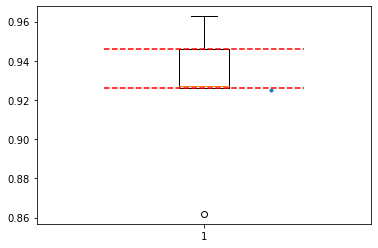

In [30]:
import matplotlib.pyplot as plt 

plt.boxplot(cv_results['test_score'])
plt.scatter(1.2,auc_test, marker='.')
plt.plot(np.arange(0.7,1.3,0.01),np.repeat(np.quantile(cv_results['test_score'],0.25),61),color='red',linestyle='--')
plt.plot(np.arange(0.7,1.3,0.01),np.repeat(np.quantile(cv_results['test_score'],0.75),61),color='red',linestyle='--')
plt.show()

Podemos observar que el valor del AUC obtenido para el paciente 10 (punto azul), se encuentra ínfimamente por debajo de los valores esperados.

In [31]:
print(classification_report(pred, hypno10['Stage']))

              precision    recall  f1-score   support

          N1       0.57      0.59      0.58       209
          N2       0.49      0.64      0.56       133
          N3       0.82      0.97      0.89        95
           R       0.51      0.99      0.67        70
           W       1.00      0.49      0.66       259

    accuracy                           0.65       766
   macro avg       0.68      0.74      0.67       766
weighted avg       0.73      0.65      0.65       766



Los resultados que obtenemos no son tan buenos como los que esperábamos puesto que hemos obtenido un AUC muy alto. Por tanto, dibujemos las curvas ROC:

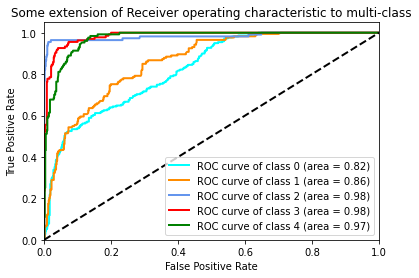

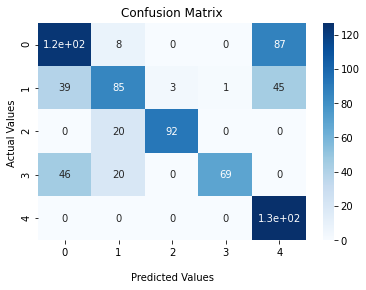

In [32]:
#LLamamos a la función que dibuja la curva ROC

draw_ROC(df10_3, hypno10['Stage'])

#Hallamos las entradas de la función que calcula la matriz de confusión

matrix = confusion_matrix(hypno10['Stage'], pred)

#LLamamos a la función que calcula la matriz de confusión

draw_ConfusionM(matrix,np.arange(0,5))

### Modificación de los umbrales de decisión

Queremos mejorar la precisión de nuestro modelo para detectar mejor las fases del sueño. Para ello primero haremos que el umbral para detectar una fase N1 sea más sensible de modo que si las probabilidades de pertenecer a las fases N2 y REM son más bajas que 0.2 y la probabilidad de pertenecer a N1 es mayor que 0.3 entonces pertenecerá a N1. De este modo trataremos de corregir la matriz de confusión y trataremos de conseguir que detecte como N1 las fases detectadas como que estaba despierto. 

De forma análoga, cuando haya conflicto entre REM y N2, le daremos preferencia a REM. 



In [33]:
y_score = clf.predict_proba(df10_3)
clase=['N1', 'N2', 'N3', 'R', 'W']
prediccion=[]
for i in range(0,y_score.shape[0]):
    if (y_score[i,0]>0.3) & (y_score[i,1]<0.2) & (y_score[i,3]<0.2):
        y_score[i,0]=0.99
    if (y_score[i,1]>0.1) & (y_score[i,3]>=0.2) & (y_score[i,1]<=0.5) : #Cuando hay conflicto entre REM y N2, tiene prioridad REM
        y_score[i,3]=0.99 

    indice_max=list(y_score[i,:]).index(max(y_score[i,:]))
    prediccion.append(clase[indice_max])

print(classification_report(pred, hypno10['Stage']))
print(classification_report(prediccion, hypno10['Stage']))

              precision    recall  f1-score   support

          N1       0.57      0.59      0.58       209
          N2       0.49      0.64      0.56       133
          N3       0.82      0.97      0.89        95
           R       0.51      0.99      0.67        70
           W       1.00      0.49      0.66       259

    accuracy                           0.65       766
   macro avg       0.68      0.74      0.67       766
weighted avg       0.73      0.65      0.65       766

              precision    recall  f1-score   support

          N1       0.66      0.70      0.68       208
          N2       0.49      0.68      0.57       123
          N3       0.82      0.97      0.89        95
           R       0.79      0.94      0.85       113
           W       0.98      0.55      0.70       227

    accuracy                           0.72       766
   macro avg       0.75      0.77      0.74       766
weighted avg       0.76      0.72      0.72       766



Podemos observar como hemos mejorados los resultados en comparación con el modelo del random forest. Aunque todavía no hemos podido detectar de forma correcta los casos de la fase N2.

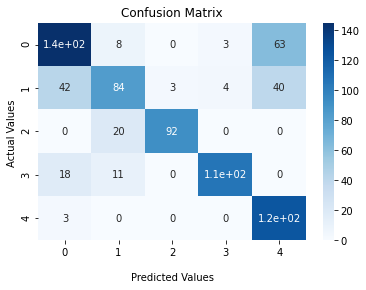

In [34]:
matrix = confusion_matrix(hypno10['Stage'], prediccion)

#LLamamos a la función que calcula la matriz de confusión

draw_ConfusionM(matrix,np.arange(0,5))

Ahora, aplicaremos esta forma de decisión al sujeto 7 y mostraremos su tabla de precission-recall y su matriz de confusión para las predicciones con el random forest y con el modelo con las modificaciones del umbral:

In [35]:
y_score = clf.predict_proba(df7_3)
clase=['N1', 'N2', 'N3', 'R', 'W']
prediccion7=[]
for i in range(0,y_score.shape[0]):
    if (y_score[i,0]>0.3) & (y_score[i,1]<0.2) & (y_score[i,3]<0.2):
        y_score[i,0]=0.99
    if (y_score[i,1]>0.1) & (y_score[i,3]>=0.2) & (y_score[i,1]<=0.5) : #Cuando hay conflicto entre REM y N2, tiene prioridad REM
        y_score[i,3]=0.99
    indice_max=list(y_score[i,:]).index(max(y_score[i,:]))
    prediccion7.append(clase[indice_max])

#Tabla para Random forest
print(classification_report(clf.predict(df7_3), hypno7['Stage']))
#Tabla para modelo con umbrales
print(classification_report(prediccion7, hypno7['Stage']))

              precision    recall  f1-score   support

          N1       0.41      0.53      0.46        49
          N2       0.88      0.59      0.70       234
          N3       0.80      0.97      0.88       215
           R       0.54      0.98      0.70        54
           W       0.96      0.85      0.90       232

    accuracy                           0.79       784
   macro avg       0.72      0.78      0.73       784
weighted avg       0.83      0.79      0.80       784

              precision    recall  f1-score   support

          N1       0.41      0.54      0.47        48
          N2       0.88      0.62      0.73       219
          N3       0.79      0.97      0.87       214
           R       0.77      0.86      0.81        87
           W       0.93      0.89      0.91       216

    accuracy                           0.81       784
   macro avg       0.76      0.78      0.76       784
weighted avg       0.83      0.81      0.81       784



Podemos observar que obtenemos mejores resultados que con el modelo random forest sin embargo en este caso no conseguimos detectar de forma correcta las fases N1 ni con el modelo del random forest ni con el de los umbrales modificados.  Sin embargo las demás fases sí que las detectamos de forma correcta

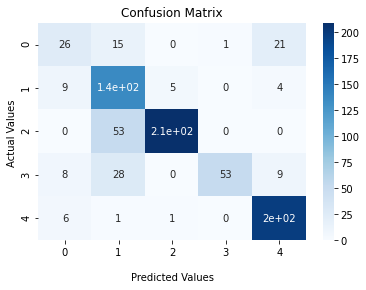

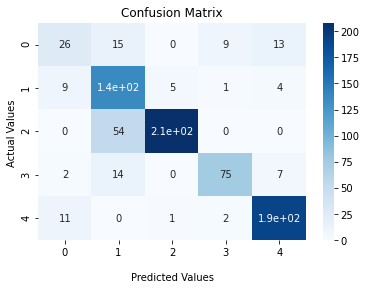

In [36]:
matrix = confusion_matrix(hypno7['Stage'], clf.predict(df7_3))

#LLamamos a la función que calcula la matriz de confusión

draw_ConfusionM(matrix,np.arange(0,5))
    
matrix = confusion_matrix(hypno7['Stage'], prediccion7)

#LLamamos a la función que calcula la matriz de confusión

draw_ConfusionM(matrix,np.arange(0,5))

## Predicciones entrenando con 8 pacientes y testeando con 24

En esta sección repetiremos el procedimiento del apartado anterior pero en este caso entrenaremos el modelo con los pacientes 2-8 y lo testearemos con los pacientes 1 y 10

In [37]:
#Cargamos el rawData del paciente 1-6

raw1 = mne.io.read_raw_edf('Data2/1/1.edf', preload=True)
raw2 = mne.io.read_raw_edf('Data2/2/2.edf', preload=True)
raw3 = mne.io.read_raw_edf('Data2/3/3.edf', preload=True)
raw4 = mne.io.read_raw_edf('Data2/4/4.edf', preload=True)
raw5 = mne.io.read_raw_edf('Data2/5/5.edf', preload=True)
raw6 = mne.io.read_raw_edf('Data2/6/6.edf', preload=True)

#Eliminamos los canales que no necesitamos
raw1.drop_channels(['X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8'])
raw2.drop_channels(['X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8'])
raw3.drop_channels(['X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8'])
raw4.drop_channels(['X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8'])
raw5.drop_channels(['X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8'])
raw6.drop_channels(['X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8'])

#Aplicamos un downsampling
raw1.resample(100)
raw2.resample(100)
raw3.resample(100)
raw4.resample(100)
raw5.resample(100)
raw6.resample(100)

#Aplicamos un filtro de pase de banda
              
raw1.filter(0.3, 49)
raw2.filter(0.3, 49)
raw3.filter(0.3, 49)
raw4.filter(0.3, 49)
raw5.filter(0.3, 49)
raw6.filter(0.3, 49)

#Multiplicamos un millo para pasar de Voltios a microVoltios

data1 = raw1.get_data() * 1e6
data2 = raw2.get_data() * 1e6
data3 = raw3.get_data() * 1e6
data4 = raw4.get_data() * 1e6
data5 = raw5.get_data() * 1e6
data6 = raw6.get_data() * 1e6

#Eliminamos las últimas 30 etapas

data1 = data1[:,0:-30*30*100]
data2 = data2[:,0:-30*30*100]
data3 = data3[:,0:-30*30*100]
data4 = data4[:,0:-30*30*100]
data5 = data5[:,0:-30*30*100]
data6 = data6[:,0:-30*30*100]

Extracting EDF parameters from C:\Users\santi\Documents\Biomedicina\trabajo_final\Data2\1\1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5723999  =      0.000 ... 28619.995 secs...
Extracting EDF parameters from C:\Users\santi\Documents\Biomedicina\trabajo_final\Data2\2\2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5645999  =      0.000 ... 28229.995 secs...
Extracting EDF parameters from C:\Users\santi\Documents\Biomedicina\trabajo_final\Data2\3\3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4943999  =      0.000 ... 24719.995 secs...
Extracting EDF parameters from C:\Users\santi\Documents\Biomedicina\trabajo_final\Data2\4\4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4763999  =      0.000 ... 23819.995 secs...
Extracting EDF parameters from C:\Users\

In [38]:
################# Paciente 1

######### DataFrame con media y desviación típica

df1_1 = pd.DataFrame()

for canal, i in zip(raw1.ch_names, np.arange(len(raw1.ch_names))):
    
    media = []
    sd = []
    nombre_var_mean = canal + '_ mean'
    nombre_var_sd = canal + '_sd'
    for intervalo in np.linspace(0, data1.shape[1], int(data1.shape[1]/3000 + 1))[1:]:
        media.append(np.mean(data1[i, int(intervalo-3000):int(intervalo)]))
        sd.append(np.std(data1[i, int(intervalo-3000):int(intervalo)]))
        
    df1_1[nombre_var_mean] = media
    df1_1[nombre_var_sd] = sd

######### DataFrame con características obtenidas por yasa

df1_2 = pd.DataFrame()

for canal in raw1.ch_names:
    
    sls = yasa.SleepStaging(raw1, eeg_name = canal)
    features = sls.get_features()
    for feat in features.columns:
        
        name_var = feat+'_'+canal
        df1_2[name_var] = features[feat]

#Quitamos las últimas 30 épocas
df1_2 = df1_2.iloc[:-30,:]

######### Obtenemos el DataFrame final

df1_3 = pd.concat([df1_1, df1_2], axis = 1)


################# Paciente 2

######### DataFrame con media y desviación típica

df2_1 = pd.DataFrame()

for canal, i in zip(raw2.ch_names, np.arange(len(raw2.ch_names))):
    
    media = []
    sd = []
    nombre_var_mean = canal + '_ mean'
    nombre_var_sd = canal + '_sd'
    for intervalo in np.linspace(0, data2.shape[1], int(data2.shape[1]/3000 + 1))[1:]:
        media.append(np.mean(data2[i, int(intervalo-3000):int(intervalo)]))
        sd.append(np.std(data2[i, int(intervalo-3000):int(intervalo)]))
        
    df2_1[nombre_var_mean] = media
    df2_1[nombre_var_sd] = sd

######### DataFrame con características obtenidas por yasa

df2_2 = pd.DataFrame()

for canal in raw2.ch_names:
    
    sls = yasa.SleepStaging(raw2, eeg_name = canal)
    features = sls.get_features()
    for feat in features.columns:
        
        name_var = feat+'_'+canal
        df2_2[name_var] = features[feat]

#Quitamos las últimas 30 épocas

df2_2 = df2_2.iloc[:-30,:]

######### Obtenemos el DataFrame final

df2_3 = pd.concat([df2_1, df2_2], axis = 1)


######################### Paciente 3

######### DataFrame con media y desviación típica

df3_1 = pd.DataFrame()

for canal, i in zip(raw3.ch_names, np.arange(len(raw3.ch_names))):
    
    media = []
    sd = []
    nombre_var_mean = canal + '_ mean'
    nombre_var_sd = canal + '_sd'
    
    for intervalo in np.linspace(0, data3.shape[1], int(data3.shape[1]/3000 + 1))[1:]:
        
        media.append(np.mean(data3[i, int(intervalo-3000):int(intervalo)]))
        sd.append(np.std(data3[i, int(intervalo-3000):int(intervalo)]))
        
    df3_1[nombre_var_mean] = media
    df3_1[nombre_var_sd] = sd

######### DataFrame con características obtenidas por yasa

df3_2 = pd.DataFrame()

for canal in raw3.ch_names:
    
    sls = yasa.SleepStaging(raw3, eeg_name = canal)
    features = sls.get_features()
    for feat in features.columns:
        
        name_var = feat+'_'+canal
        df3_2[name_var] = features[feat]

#Quitamos las últimas 30 épocas
df3_2 = df3_2.iloc[:-30,:]

######### Obtenemos el DataFrame final

df3_3 = pd.concat([df3_1, df3_2], axis = 1)


######################### Paciente 4

######### DataFrame con media y desviación típica

df4_1 = pd.DataFrame()

for canal, i in zip(raw4.ch_names, np.arange(len(raw4.ch_names))):
    
    media = []
    sd = []
    nombre_var_mean = canal + '_ mean'
    nombre_var_sd = canal + '_sd'
    for intervalo in np.linspace(0, data4.shape[1], int(data4.shape[1]/3000 + 1))[1:]:
        media.append(np.mean(data4[i, int(intervalo-3000):int(intervalo)]))
        sd.append(np.std(data4[i, int(intervalo-3000):int(intervalo)]))
        
    df4_1[nombre_var_mean] = media
    df4_1[nombre_var_sd] = sd

######### DataFrame con características obtenidas por yasa

df4_2 = pd.DataFrame()

for canal in raw4.ch_names:
    
    sls = yasa.SleepStaging(raw4, eeg_name = canal)
    features = sls.get_features()
    for feat in features.columns:
        
        name_var = feat+'_'+canal
        df4_2[name_var] = features[feat]

#Quitamos las últimas 30 épocas
df4_2 = df4_2.iloc[:-30,:]

######### Obtenemos el DataFrame final

df4_3 = pd.concat([df4_1, df4_2], axis = 1)

######################### Paciente 5

######### DataFrame con media y desviación típica

df5_1 = pd.DataFrame()

for canal, i in zip(raw5.ch_names, np.arange(len(raw5.ch_names))):
    
    media = []
    sd = []
    nombre_var_mean = canal + '_ mean'
    nombre_var_sd = canal + '_sd'
    for intervalo in np.linspace(0, data5.shape[1], int(data5.shape[1]/3000 + 1))[1:]:
        media.append(np.mean(data5[i, int(intervalo-3000):int(intervalo)]))
        sd.append(np.std(data5[i, int(intervalo-3000):int(intervalo)]))
        
    df5_1[nombre_var_mean] = media
    df5_1[nombre_var_sd] = sd

######### DataFrame con características obtenidas por yasa

df5_2 = pd.DataFrame()

for canal in raw5.ch_names:
    
    sls = yasa.SleepStaging(raw5, eeg_name = canal)
    features = sls.get_features()
    for feat in features.columns:
        
        name_var = feat+'_'+canal
        df5_2[name_var] = features[feat]

#Quitamos las últimas 30 épocas
df5_2 = df5_2.iloc[:-30,:]

######### Obtenemos el DataFrame final

df5_3 = pd.concat([df5_1, df5_2], axis = 1)

######################### Paciente 6

######### DataFrame con media y desviación típica

df6_1 = pd.DataFrame()

for canal, i in zip(raw6.ch_names, np.arange(len(raw6.ch_names))):
    
    media = []
    sd = []
    nombre_var_mean = canal + '_ mean'
    nombre_var_sd = canal + '_sd'
    for intervalo in np.linspace(0, data6.shape[1], int(data6.shape[1]/3000 + 1))[1:]:
        media.append(np.mean(data6[i, int(intervalo-3000):int(intervalo)]))
        sd.append(np.std(data6[i, int(intervalo-3000):int(intervalo)]))
        
    df6_1[nombre_var_mean] = media
    df6_1[nombre_var_sd] = sd

######### DataFrame con características obtenidas por yasa

df6_2 = pd.DataFrame()

for canal in raw6.ch_names:
    
    sls = yasa.SleepStaging(raw6, eeg_name = canal)
    features = sls.get_features()
    for feat in features.columns:
        
        name_var = feat+'_'+canal
        df6_2[name_var] = features[feat]

#Quitamos las últimas 30 épocas
df6_2 = df6_2.iloc[:-30,:]

######### Obtenemos el DataFrame final

df6_3 = pd.concat([df6_1, df6_2], axis = 1)

Unimos los datos de los pacientes 2 al 9 y la de los pacientes 1y 10:

In [39]:
df_modelo = pd.concat([df2_3,df3_3,df4_3,df5_3,df6_3,df7_3,df8_3, df9_3], axis = 0)
df_test=pd.concat([df1_3,df10_3], axis=0)

#Mostramos el DataFrame
df_modelo

,LOC-A2_ mean,LOC-A2_sd,ROC-A1_ mean,ROC-A1_sd,F3-A2_ mean,F3-A2_sd,C3-A2_ mean,C3-A2_sd,O1-A2_ mean,O1-A2_sd,...,eeg_skew_c7min_norm_X3,eeg_skew_p2min_norm_X3,eeg_std_X3,eeg_std_c7min_norm_X3,eeg_std_p2min_norm_X3,eeg_theta_X3,eeg_theta_c7min_norm_X3,eeg_theta_p2min_norm_X3,time_hour_X3,time_norm_X3
0,0.021414,3.444510,0.001682,5.591182,-0.012521,2.173616,-0.008547,2.132537,-0.004896,2.763572,...,-0.058731,-0.494637,1.035526,0.403983,0.559317,0.010933,0.097095,-0.957878,0.000000,0.000000
1,-0.016822,1.599259,-0.003065,1.682684,0.012589,1.377043,0.010285,1.318787,0.006303,1.555036,...,0.073244,-1.354265,1.547758,0.351635,0.708732,0.037778,0.153887,-0.053910,0.008333,0.001064
2,-0.004557,1.343397,-0.011236,1.408271,0.007369,1.246311,0.006748,1.222165,0.004826,1.304247,...,0.281332,-0.135913,0.186331,0.271161,0.493791,0.025248,0.169720,-0.033883,0.016667,0.002128
3,0.003745,1.338934,0.003091,1.376860,-0.011773,1.159512,-0.011454,1.175242,-0.000669,1.206746,...,0.335942,-0.146820,0.082481,0.209782,0.371174,0.030522,0.191472,0.064938,0.025000,0.003191
4,0.000374,1.170377,0.007378,1.387098,0.004539,1.163517,0.005749,1.174626,-0.004379,1.157106,...,0.386996,-0.214064,0.100327,0.162652,0.234778,0.033984,0.198913,0.453044,0.033333,0.004255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934,0.007193,1.274878,-0.012301,2.030962,0.014096,2.440941,0.015095,1.984322,0.016569,1.281736,...,-0.028344,-0.082277,0.042864,-0.086425,-0.031924,0.028652,0.184451,0.059409,7.783333,0.964876
935,-0.015678,1.466535,-0.000296,2.192913,-0.013773,2.951060,-0.010499,2.546502,-0.004194,1.619301,...,0.033182,-0.084054,0.044584,-0.038330,-0.032010,0.031036,0.151544,0.131952,7.791667,0.965909
936,0.000397,1.440653,0.012946,1.529761,-0.000924,2.209169,-0.006265,2.035833,-0.009173,1.353349,...,0.095037,-0.161787,0.048829,0.024858,-0.031443,0.028552,0.073661,0.192399,7.800000,0.966942
937,0.001689,0.924428,-0.012679,1.004306,0.005802,1.336225,0.007396,1.299003,0.005644,1.115177,...,0.176719,-0.111306,0.045469,0.107815,-0.031509,0.027470,-0.037472,0.222537,7.808333,0.967975


Ahora solo nos faltan tener las etiquetas de las fases de cada paciente, por lo que cargaremos los hipnogramas que nos faltaban:

In [40]:
hypno1 = pd.read_excel("Data2/1/1_1.xlsx", squeeze = True)
hypno1 =hypno1.iloc[0:hypno1.shape[0]-30]

hypno2 = pd.read_excel("Data2/2/2_1.xlsx", squeeze = True)
hypno2 = hypno2.iloc[0:hypno2.shape[0]-30]

hypno3 = pd.read_excel("Data2/3/3_1.xlsx", squeeze = True)
hypno3 = hypno3.iloc[0:hypno3.shape[0]-30]

hypno4 = pd.read_excel("Data2/4/4_1.xlsx", squeeze = True)
hypno4 = hypno4.iloc[0:hypno4.shape[0]-30]

hypno5 = pd.read_excel("Data2/5/5_1.xlsx", squeeze = True)
hypno5 = hypno5.iloc[0:hypno5.shape[0]-30]

hypno6 = pd.read_excel("Data2/6/6_1.xlsx", squeeze = True)
hypno6 = hypno6.iloc[0:hypno6.shape[0]-30]


#Unimos las clasificaciones de los pacientes 2-9 y también las de los pacientes 1 y 10
hypno_modelo = pd.concat([hypno2,hypno3,hypno4,hypno5,hypno6,hypno7,hypno8, hypno9], axis = 0) 
hypno_test = pd.concat([hypno1, hypno10], axis = 0) 


Ya tenemos todos los DataFrame que necesitamos. Lo que haremos ahora será entrenar un `RandomForest` donde los datos de entrenamiento es el DataFrame de los pacientes del 2 al 9 y luego testeamos con los pacientes 1 y 10. Para ver el rendimiento del modelo, en vez de hallar una único valor de una métrica (en este el _AUC_), lo que haremos será obtener su variabilidad en el conjunto de entrenamiento utilizando _Cross Validation_ ya que, al testear en los pacientes 1 y 10, podemos ver si el _AUC_ que obtenemos al predecir, están dentro de la esperado o no. Por tanto, tenemos:

In [41]:
clf=0
clf = RandomForestClassifier(random_state=0)
cv_results = cross_validate(clf, df_modelo, hypno_modelo['Stage'], cv=10, scoring='roc_auc_ovr')
cv_results

{'fit_time': array([16.78612185, 16.16580987, 16.2648344 , 15.64014745, 16.15772772,
        16.37119198, 17.30668855, 17.04438496, 16.51884675, 16.02611661]),
 'score_time': array([0.05952191, 0.04104257, 0.03587365, 0.03805542, 0.0378983 ,
        0.03690004, 0.03996396, 0.03690147, 0.03486991, 0.03889489]),
 'test_score': array([0.94201847, 0.95767042, 0.92624189, 0.92788403, 0.95033578,
        0.95235605, 0.94299074, 0.96146303, 0.95536619, 0.94861097])}

Ahora veamos como se comporta el modelo con los datos de testeo:

In [42]:
#Entrenamos el modelo y hallamos las predicciones

clf = OneVsRestClassifier(RandomForestClassifier(random_state=0))
clf.fit(df_modelo, hypno_modelo['Stage'])
pred = clf.predict(df_test)

#Obtenemos los resultados de la predicción 

auc_test=roc_auc_score(hypno_test['Stage'], clf.predict_proba(df_test),multi_class='ovr')
auc_test

0.9665361915477029

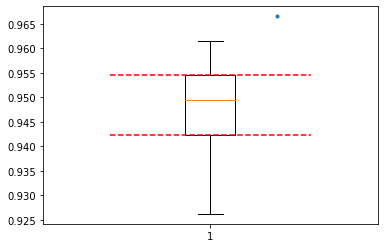

In [43]:
plt.boxplot(cv_results['test_score'])
plt.scatter(1.2,auc_test, marker='.')
plt.plot(np.arange(0.7,1.3,0.01),np.repeat(np.quantile(cv_results['test_score'],0.25),61),color='red',linestyle='--')
plt.plot(np.arange(0.7,1.3,0.01),np.repeat(np.quantile(cv_results['test_score'],0.75),61),color='red',linestyle='--')
plt.show()

Como podemos observar, en este caso obtenemos un AUC bastante más elevado de lo esperado

In [44]:
print(classification_report(pred, hypno_test['Stage']))

              precision    recall  f1-score   support

          N1       0.47      0.79      0.59       197
          N2       0.85      0.79      0.82       581
          N3       0.86      0.95      0.91       262
           R       0.85      0.93      0.89       217
           W       0.97      0.64      0.77       433

    accuracy                           0.80      1690
   macro avg       0.80      0.82      0.79      1690
weighted avg       0.84      0.80      0.80      1690



Obtenemos unos resultados bastante buenos para todas las fases a excepción de la fase N1. Esto se ve reflejado en la curva ROC ya que la curva correspondiente a la clase N1 (azul clarito) es la más baja de todas por lo que lo más seguro es que tengamos que modificar los umbrales para poder mejorar los resultados:

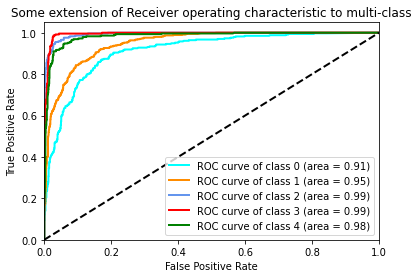

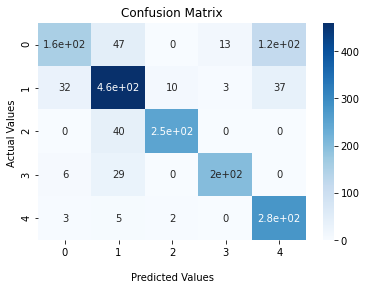

In [45]:
#LLamamos a la función que dibuja la curva ROC

draw_ROC(df_test, hypno_test['Stage'])

#Hallamos las entradas de la función que calcula la matriz de confusión

matrix = confusion_matrix(hypno_test['Stage'], pred)

#LLamamos a la función que calcula la matriz de confusión

draw_ConfusionM(matrix,np.arange(0,5))

Si nos fijamos en la matriz de confusión el problema está en que nuestro modelo no consigue distinguir de forma correcta entre la fase N1 y cuando el sujeto se encuentra despierto. Por tanto, ahora procederemos a modificar los umbrales de modo que necesitemos una probabilidad más elevada para decidir que el sujeto esté despierto.

Aparte de esto, podemos observar que en el resto de fases obtenemos unos resultados bastante buenos.

### Reducción de variables
Veamos ahora como se comportaría el modelo si le bajamos la cantidad de variables:

In [150]:
X_train, X_test, y_train, y_test = train_test_split(df_modelo, hypno_modelo['Stage'], test_size=0.33, random_state=999)

#Creamos el modelo

clf_var = RandomForestClassifier(random_state=0)
clf_var.fit(X_train, y_train)
pred_var=clf_var.predict(X_test)

#Seleccionamos las variables
variables=pd.DataFrame({"Variables":df_modelo.columns[index[0:75]]})

In [155]:
print(variables['Variables'].head(10))

0               eeg_beta_F3-A2
1     eeg_nzc_c7min_norm_F4-A1
2                 eeg_db_F3-A2
3             eeg_fdelta_F3-A2
4             eeg_fdelta_C3-A2
5    eeg_hmob_c7min_norm_O2-A1
6            eeg_higuchi_O2-A1
7    eeg_hmob_c7min_norm_C4-A1
8                 eeg_at_O2-A1
9     eeg_nzc_c7min_norm_O2-A1
Name: Variables, dtype: object


Ahora entrenamos el modelo con las 75 variables más importantes:

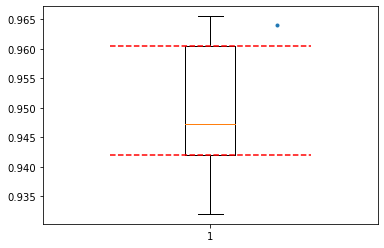

In [107]:
clf=0
clf = RandomForestClassifier(random_state=0)
cv_results = cross_validate(clf, df_modelo[variables['Variables']], hypno_modelo['Stage'], cv=10, scoring='roc_auc_ovr')
cv_results
plt.boxplot(cv_results['test_score'])
plt.scatter(1.2,auc_test, marker='.')
plt.plot(np.arange(0.7,1.3,0.01),np.repeat(np.quantile(cv_results['test_score'],0.25),61),color='red',linestyle='--')
plt.plot(np.arange(0.7,1.3,0.01),np.repeat(np.quantile(cv_results['test_score'],0.75),61),color='red',linestyle='--')
plt.show()

Podemos observar que tenemos un AUC un poquito más elevado de lo esperado

In [108]:
clf = OneVsRestClassifier(RandomForestClassifier(random_state=0))
clf.fit(df_modelo[variables['Variables']], hypno_modelo['Stage'])
pred = clf.predict(df_test[variables['Variables']])

#Obtenemos los resultados de la predicción 

auc_test=roc_auc_score(hypno_test['Stage'], clf.predict_proba(df_test[variables['Variables']]),multi_class='ovr')
auc_test

0.9641265049822205

In [109]:
print(classification_report(pred, hypno_test['Stage']))

              precision    recall  f1-score   support

          N1       0.50      0.76      0.60       216
          N2       0.84      0.81      0.82       560
          N3       0.87      0.95      0.91       263
           R       0.83      0.91      0.87       217
           W       0.97      0.65      0.78       434

    accuracy                           0.80      1690
   macro avg       0.80      0.82      0.80      1690
weighted avg       0.83      0.80      0.80      1690



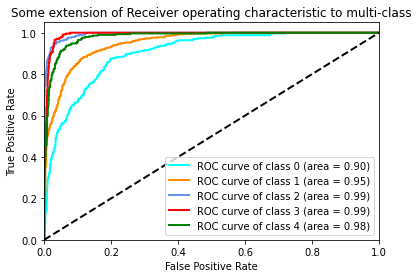

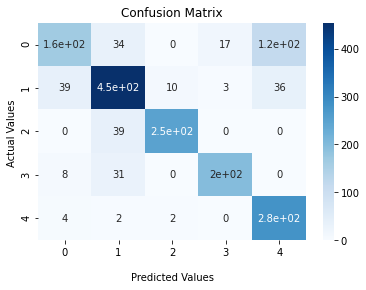

In [110]:
#LLamamos a la función que dibuja la curva ROC

draw_ROC(df_test[variables['Variables']], hypno_test['Stage'])

#Hallamos las entradas de la función que calcula la matriz de confusión

matrix = confusion_matrix(hypno_test['Stage'], pred)

#LLamamos a la función que calcula la matriz de confusión

draw_ConfusionM(matrix,np.arange(0,5))

Podemos observar que obtenemos resultados muy parecidos a los anteriores con la ventaja de tener 75 variables en vez de 737. Las matrices de confusión también son similares a las anteriores por tanto, nos quedaremos con este modelo por sen más sencillo que los anteriores y procederemos a modificar los umbrales del modelo con 75 variables

### Modificación de umbrales

Ahora modificaremos los umbrales que comentamos anteriormente. Para ello simplemente haremos que si la probabilidad de que esté en la fase N1 es superior al 20% y la probabilidad de que esté despierto sea mayor que la de que esté en fase N1, entonces diremos que la fase es N1. 

In [132]:
y_score = clf.predict_proba(df_test[variables['Variables']])
clase=['N1', 'N2', 'N3', 'R', 'W']
prediccion_test=[]
for i in range(0,y_score.shape[0]):
    if (y_score[i,0]>0.2) & (y_score[i,4]>y_score[i,0]):
        y_score[i,0]=y_score[i,0]+y_score[i,4]
    indice_max=list(y_score[i,:]).index(max(y_score[i,:]))
    prediccion_test.append(clase[indice_max])

#Tabla para Random forest
print(classification_report(clf.predict(df_test[variables['Variables']]), hypno_test['Stage']))
#Tabla para modelo con umbrales
print(classification_report(prediccion_test, hypno_test['Stage']))

              precision    recall  f1-score   support

          N1       0.50      0.76      0.60       216
          N2       0.84      0.81      0.82       560
          N3       0.87      0.95      0.91       263
           R       0.83      0.91      0.87       217
           W       0.97      0.65      0.78       434

    accuracy                           0.80      1690
   macro avg       0.80      0.82      0.80      1690
weighted avg       0.83      0.80      0.80      1690

              precision    recall  f1-score   support

          N1       0.77      0.67      0.72       378
          N2       0.82      0.80      0.81       550
          N3       0.86      0.95      0.90       261
           R       0.83      0.91      0.87       216
           W       0.83      0.85      0.84       285

    accuracy                           0.82      1690
   macro avg       0.82      0.84      0.83      1690
weighted avg       0.82      0.82      0.82      1690



Podemos observar que a pesar de que empeoramos la precisión ponderada, hemos conseguido mejorar la precisión de la fase N1. Aparte de esto hemos mejorado notablemente el recall y el f1-score, por lo que podemos decir que esta modificación de los umbrales ha sido buena.

Otro posible planteamiento podría ser el de seleccionar las dos probabilidades más altas, de este modo en vez de determinar una fase en concreto, tendríamos un modelo que sirviese de apoyo a la hora de la toma de decisiones de un profesional.

### Modelo subrogado

Ahora, procederemos a realizar un modelo subrogado, de este modo veremos si nuestro modelo se está comportando como un clasificador lineal (por lo que no tendría sentido trabajar con un modelo más complejo como es el random forest)

Primero, obtendremos las etiquetas obtenidas por nuestro modelo con los umbrales modificados ya que este vector de etiquetas lo utilizaremos para entrenar el modelo subrogado. De este modo veremos si el modelo subrogado de comporta igual que nuestro modelo de random forest con los umbrales modificados

In [138]:
y_score = clf.predict_proba(df_modelo[variables['Variables']])
clase=['N1', 'N2', 'N3', 'R', 'W']
prediccion_train=[]
for i in range(0,y_score.shape[0]):
    if (y_score[i,0]>0.2) & (y_score[i,4]>y_score[i,0]):
        y_score[i,0]=y_score[i,0]+y_score[i,4]
    indice_max=list(y_score[i,:]).index(max(y_score[i,:]))
    prediccion_train.append(clase[indice_max])

En este caso utilizaremos un SVC como modelo subrogado. Entrenaremos con df_modelo y el vector prediccion_train y posteriormente observaremos como se comportan ambos modelos:

In [148]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

SVC = make_pipeline(StandardScaler(), SVC(gamma='auto'))
SVC.fit(df_modelo[variables['Variables']], prediccion_train)

prediccion_SVC=SVC.predict(df_test[variables['Variables']])
print(classification_report(prediccion_SVC, prediccion_test))

              precision    recall  f1-score   support

          N1       0.50      0.89      0.64       212
          N2       0.94      0.89      0.92       578
          N3       0.97      0.97      0.97       261
           R       0.97      0.93      0.95       225
           W       0.98      0.67      0.80       414

    accuracy                           0.86      1690
   macro avg       0.87      0.87      0.86      1690
weighted avg       0.90      0.86      0.87      1690



Esta tabla nos refleja cuanto se parecen nuestros dos modelos. De este modo podemos observar que su comportamiento es muy parecido en todas las clases a excepción de con la clase N1, donde el modelo subrogado no consigue identificar correctamente las salidas de nuestro modelo con los umbrales modificados. Es decir, para la fase N1, el modelo simple no es capaz de comportarse igual que nuestro modelo más complejo.

Por tanto, aunque ambos modelos son muy parecidos, consideramos que sería mejor quedarnos con el modelo de random forest con modificación de umbrales ya que conseguimos diferenciar mejor las fases N1 y cuando está despierto.

In [149]:
print(classification_report(prediccion_SVC, hypno_test['Stage']))
print(classification_report(prediccion_test, hypno_test['Stage']))

              precision    recall  f1-score   support

          N1       0.47      0.74      0.57       212
          N2       0.86      0.80      0.83       578
          N3       0.86      0.96      0.91       261
           R       0.84      0.88      0.86       225
           W       0.97      0.68      0.80       414

    accuracy                           0.80      1690
   macro avg       0.80      0.81      0.79      1690
weighted avg       0.84      0.80      0.81      1690

              precision    recall  f1-score   support

          N1       0.77      0.67      0.72       378
          N2       0.82      0.80      0.81       550
          N3       0.86      0.95      0.90       261
           R       0.83      0.91      0.87       216
           W       0.83      0.85      0.84       285

    accuracy                           0.82      1690
   macro avg       0.82      0.84      0.83      1690
weighted avg       0.82      0.82      0.82      1690



Así si hacemos una tabla precision-recall para ambas predicciones podemos observar que con el modelo más complejo obtenemos mejores resultados ya que disminuye muy ligeramente la precisión global pero aumenta más el recall. Esto se ve reflejado en el f1-score donde tenemos un valor mayor con el modelo más complejo

### HIPNOGRAMA

Estudiemos ahora el hipnograma. Volvemos a cargar los datos: 

In [46]:
hypno = pd.read_excel("Data2/10/10_1.xlsx", squeeze = True)

#Le quitamos las últimas 30 épocas

hypno = hypno.iloc[0:hypno.shape[0]-30]
hypno

,Epoch,Stage,SpO2,HR,Events,BPOS,Txln,TxEx,Technote,Unnamed: 9,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,1,W,0,104,NaN,R,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PAGE 13/13
1,2,W,0,83 L Out,NaN,R,0,0,0,00:32:49 - LIGHTS OUT,...,ID:,068/09,NaN,NaN,NaN,NaN,NaN,PHY:,NaN,NaN
2,3,W,0,93,NaN,R,0,0,0,NaN,...,NaN,7/3/2009,NaN,NaN,NaN,NaN,NaN,ROOM:,NaN,NaN
3,4,W,0,90,NaN,R,0,0,0,NaN,...,NaN,in,WEIGHT:,lbs,NaN,NaN,NaN,AGE:,33,NaN
4,5,W,50,169,NaN,B,0,0,0,NaN,...,NaN,cm,NaN,kg,NaN,NaN,NaN,SEX:,Male,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,762,N3,99,68,NaN,L,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
762,763,N3,99,73,NaN,L,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
763,764,N3,99,72,NaN,L,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
764,765,W,99,96,NaN,L,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Para poder usar las etiquetas, tenemos que codificar la columna `Stage`, la cual representa la fase del sueño en la que está el paciente. La codificaremos de la siguiente manera: W = 0, N1 = 1, N2 = 2, N3 = 3, R = 4. Lo hacemos de la siguiente manera:

In [47]:
stage_list=np.asarray(hypno["Stage"])

stage_list[stage_list=="W"]=0
stage_list[stage_list=="N1"]=1
stage_list[stage_list=="N2"]=2
stage_list[stage_list=="N3"]=3
stage_list[stage_list=="R"]=4

Ahora, podemos representar el hipnograma:

<AxesSubplot:xlabel='Time [hrs]', ylabel='Stage'>

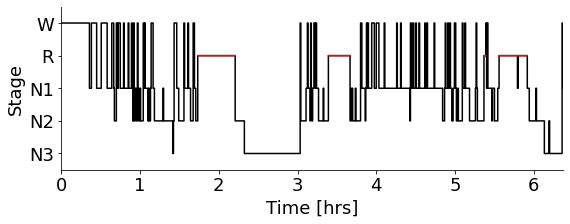

In [48]:
yasa.plot_hypnogram(stage_list)